# Development of new features for polymerist

## Developing monomer graphs

In [1]:
import networkx as nx
from rdkit import Chem

import mbuild
from mbuild.compound import Compound
from mbuild.conversion import load, load_smiles, from_rdkit, to_smiles, to_pybel
from mbuild.lib.recipes.polymer import Polymer

comp = mbuild.Compound()

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from .xtc import XTCTrajectoryFile
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mdtraj/geometry/order.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mbuild/recipes/__i

### String/graph translation (SMILES-like)

In [2]:
from polymerist.polymers.monographs import MonomerGraph

In [3]:
from openff.interchange.drivers import gromacs
from openff.interchange import Interchange

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


In [24]:
# test = f'<tests[-2]>.<tests[-2]>'
tests = [
    '[a]<-1>[A](<2-3>[Bee]<2=5>[C]<5=2>[Bee]<3-6>[Bee])(<2-3>[Bee](<3-6>[Bee])<3->[a])<->[A]<2-2>[Bee]<3-6>[Bee]',
    '[A]<1-2>[B]<6=5>[C](<4=3>[E])<#>[D]',
]
seq = [0, 1]
test = '.'.join(tests[i] for i in seq)
print(test)

[a]<-1>[A](<2-3>[Bee]<2=5>[C]<5=2>[Bee]<3-6>[Bee])(<2-3>[Bee](<3-6>[Bee])<3->[a])<->[A]<2-2>[Bee]<3-6>[Bee].[A]<1-2>[B]<6=5>[C](<4=3>[E])<#>[D]


In [25]:
tail = '[tail]<2-0>' * 10 + '[tail_end]'
lipid = f'[A3](<4-3>[A2]{tail})(<4-3>[A2]{tail})<2-0>{tail}'

In [26]:
b1 = '<->[A3](<=>[B0])<=>[B0]'
b2 = '<->[B2]<->[A3](<=>[B0])<->[B2]'
b3 = '[A3]<->[B(<->[B2])<->[B2]'
branched = f'[A3]({b2}{b1})({b2}{b2}{b1})({b2}({b1}){b2}{b1})'
branched

'[A3](<->[B2]<->[A3](<=>[B0])<->[B2]<->[A3](<=>[B0])<=>[B0])(<->[B2]<->[A3](<=>[B0])<->[B2]<->[B2]<->[A3](<=>[B0])<->[B2]<->[A3](<=>[B0])<=>[B0])(<->[B2]<->[A3](<=>[B0])<->[B2](<->[A3](<=>[B0])<=>[B0])<->[B2]<->[A3](<=>[B0])<->[B2]<->[A3](<=>[B0])<=>[B0])'

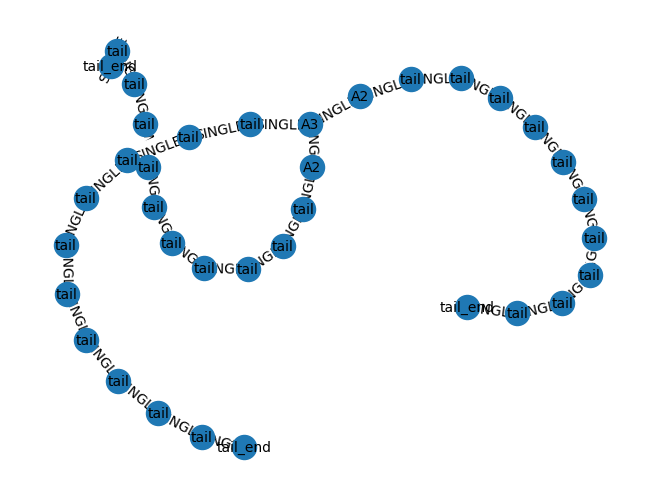

In [33]:
targ_smidge = test
targ_smidge = lipid
# targ_smidge = branched

G = MonomerGraph.from_SMIDGE(targ_smidge)
G.visualize(label_monomers=True, label_bonds=True, font_size=10, font_color='black', pos=nx.spring_layout(G))#nx.kamada_kawai_layout(G))

In [ ]:
{i : 5*v for i, v in nx.spring_layout(G).items()}

In [ ]:
rep = G.to_SMIDGE(start_node_idxs=6)
H = MonomerGraph.from_SMIDGE(rep)
H.draw()

### "Alphabet" of monomer fragment chemical information 

In [ ]:
from string import ascii_uppercase 
from polymerist.polymers.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_ports
from polymerist.rdutils.labeling.molwise import clear_atom_map_nums


parent_monomers = {
    'ethane-1,2-diol' : 'OCCO',
    'furan-2,5-dicarboxylic acid' : 'O=C(O)c1ccc(C(=O)O)o1',
}
monomer_aliases = {
    mononame : lett*3
        for mononame, lett in zip(parent_monomers.keys(), ascii_uppercase)
}

monogrp = MonomerGroup.from_file('poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic acid).json')
moldict, monosmiles = {}, {}
for mononame, rdmol in monogrp.iter_rdmols():
    for i, port in enumerate(get_ports(rdmol)):
        rdmol.GetAtomWithIdx(port.linker.GetIdx()).SetIsotope(i)

    print(mononame)
    display(rdmol)
    moldict[   mononame] = rdmol
    monosmiles[mononame] = Chem.MolToSmiles(clear_atom_map_nums(rdmol))

### Defining monomer information 

In [ ]:
from typing import Optional, ClassVar
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from dataclasses import dataclass, field


from polymerist.genutils.fileutils.jsonio.jsonify import make_jsonifiable, dataclass_serializer_factory
from polymerist.genutils.fileutils.jsonio.serialize import JSONSerializable, TypeSerializer
from polymerist.rdutils.bonding.portlib import get_num_linkers, get_num_ports
from polymerist.polymers.monomers.specification import expanded_SMILES, compliant_mol_SMARTS


@make_jsonifiable
@dataclass
class MonomerFragmentInfo:
    '''Naming and in-line chemical encodings for a monomer unit within a polymer chain'''
    name   : str
    smiles : str
    exp_smiles : Optional[str] = field(default=None, init=False, repr=False)
    smarts     : Optional[str] = field(default=None)
    category   : Optional[str] = field(default=None)

    n_atoms       : int = field(init=False)
    functionality : int = field(init=False)
    contribution  : int = field(init=False)

    FOO : ClassVar[str] = 'extra bits'

    def __post_init__(self) -> None:
        self.exp_smiles = expanded_SMILES(self.smiles, assign_map_nums=True)
        if self.smarts is None:
            self.smarts = compliant_mol_SMARTS(self.exp_smiles)

        tempmol = self.rdmol
        self.n_atoms = tempmol.GetNumAtoms()
        self.functionality = get_num_ports(tempmol) # get_num_linkers(tempmol) 
        self.contribution = self.n_atoms - self.functionality

    @property
    def rdmol(self) -> Chem.Mol:
        return Chem.MolFromSmiles(self.smiles, sanitize=False)

In [ ]:
from polymerist.polymers.monomers import specification

mono_infos = {}
for mononame, smiles in monosmiles.items():
    parent_mononame = mononame.split('_')[0]
    parent_smiles = parent_monomers[parent_mononame]
    parent_alias  = monomer_aliases[parent_mononame]

    mono_info = MonomerFragmentInfo(
        name=mononame,
        smiles=smiles,
        # smarts=specification.compliant_mol_SMARTS(smiles),
        category=parent_smiles,
    )
    alias = parent_alias.lower() if (mono_info.functionality == 1) else parent_alias.upper()
    mono_infos[alias] = mono_info
mono_infos

### Defining polymer composition class

In [ ]:
from enum import Enum, StrEnum, auto

from polymerist.genutils.fileutils.jsonio.serialize import JSONSerializable, TypeSerializer, MultiTypeSerializer
from polymerist.genutils.fileutils.jsonio.jsonify import make_jsonifiable, JSONifiable
from polymerist.polymers.monographs import MonomerGraph, MonomerGraphSerializer
from polymerist.rdutils.bonding.portlib import get_num_linkers, get_ports


MONOMER_CHARS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
class MonomerNeighborMismatch(Enum):
    '''For annotating the various ways in which a piece of monomer information in a monomer alphabet does not match a monomer graph'''
    NONE = 0
    COUNT = auto()
    BONDTYPE = auto()
    NO_FLAVOR = auto()
    DIFF_FLAVOR = auto()
    NOT_NEIGHBORS = auto()


@make_jsonifiable(type_serializer=MultiTypeSerializer(MonomerGraphSerializer, MonomerFragmentInfo.serializer))
@dataclass
class PolymerStructure:
    '''Encodes a multi-scale structural representation of a polymer topology'''
    mono_alphabet : dict[str, MonomerFragmentInfo] 
    monograph : MonomerGraph

    single_char_mononames : dict[str, str] = field(default_factory=dict, init=False) 

    def __post_init__(self) -> None:
        '''Post-process init attributes'''
        self.single_char_mononames = { # remapping from the assigned monomers names to single characters for mbuild compatibility
            mononame : remap_char
                for (mononame, remap_char) in zip(self.mono_alphabet.keys(), MONOMER_CHARS)
        }

        self.validate_monoinfo_is_compatible() # will raise targetted exceptions if incompatible
        self.assign_monoinfo_to_monograph()

    @property
    def node_info_map(self) -> dict[int, MonomerFragmentInfo]:
        '''Map from node indices to relevant monomer information'''
        return {
            node_id : self.mono_alphabet[alias]
                for node_id, alias in nx.get_node_attributes(self.monograph, self.monograph.MONOMER_NAME_ATTR).items()
        }
    
    @property
    def pdb_substructures(self) -> dict[str, list[str]]:
        '''Substructure dict formatted for the OpenFF Topology.from_pdb RDKit wrapper hook'''
        return {
            monoinfo.name : [mono_info.smarts]
                for monoinfo in self.mono_alphabet.values()
        }
    
    @property
    def num_atoms(self) -> int:
        '''Total number of atoms in the topology specified'''
        return sum(nx.get_node_attributes(self.monograph, 'contribution').values())

    # validation
    def monoalpha_surjective_to_monograph(self) -> bool:
        '''Check whether the monomer alphabet covers all monomer types defined in the Graph'''
        return self.monograph.unique_monomer_names.issubset(set(self.mono_alphabet.keys()))

    def monoalpha_neighbors_are_valid(self) -> tuple[bool, int, MonomerNeighborMismatch]:
        '''Determine whether and why adjacent monomers in the monomer graph do (or don't) have compatible chemical info'''
        for node_idx, neighbor_dict in self.monograph.adj.items():
            # 1) check that the number of neighbors in the graph matches the number of intermonomer bonding sites given chemically
            neighbor_dict = dict(neighbor_dict) # convert from networkx object to vanilla dict
            degree = len(neighbor_dict) # self.monograph.degree[node_idx]
            if (degree != self.node_info_map[node_idx].functionality):
                return False, node_idx, MonomerNeighborMismatch.COUNT
            
            # 2) check that all reported neighbor nodes are actually adjacent in the graph
            found_ports = set()
            for i, flavor in self.monograph.get_flavor_dict(node_idx).items():
                if i not in neighbor_dict:
                    return False, node_idx, MonomerNeighborMismatch.NOT_NEIGHBORS
                
                nb_bond_info = neighbor_dict.pop(i)
                found_ports.add( (flavor, nb_bond_info[self.monograph.BONDTYPE_ATTR]) )

            # 3) check that every neighbors has been provided a flavor
            if neighbor_dict:
                return False, node_idx, MonomerNeighborMismatch.NO_FLAVOR # at least one of the neighbors must nnot have had a flavor provided

            # 4) check that the provided flavors match those chemically specified
            monoinfo = self.mono_alphabet[self.monograph.get_monomer_name(node_idx)]
            portinfo = set(
                (port.flavor, port.bond.GetBondType())
                    for port in get_ports(monoinfo.rdmol)
            )
            if (portinfo != found_ports):
                return False, node_idx, MonomerNeighborMismatch.DIFF_FLAVOR
        else:
            return True, -1, MonomerNeighborMismatch.NONE
        
    def validate_monoinfo_is_compatible(self) -> None:
        if not self.monoalpha_surjective_to_monograph():
            raise ValueError('Provided monomer alphabet does not cover all monomers in the corresponding monomer graph')
        
        nb_match, mismatch_idx, reason = self.monoalpha_neighbors_are_valid()
        if not nb_match:
            raise ValueError(f'Graph node {mismatch_idx} (designation "{self.monograph.get_monomer_name(mismatch_idx)}") mismatched (reason : {reason.name})')
    
    def assign_monoinfo_to_monograph(self) -> None:
        '''Map the chemical info for each unique monomer onto corresponding monomer nodes in the monomer graph'''
        node_info_map = {
            node_idx : self.mono_alphabet[self.monograph.monomer_name(node_idx)].__dict__
                for node_idx in self.monograph.nodes
        }
        nx.set_node_attributes(self.monograph, node_info_map)

In [ ]:
import networkx as nx
from polymerist.genutils.textual import delimiters
from polymerist.polymers.monographs import MonomerGraph

smidge = 'aBABABABa'
# smidge = '{2-3}'.join(smidge)
# smidge = '{0-1}'.join(smidge)
smidge = '<0-1>'.join(smidge[:-1]) + '<0-0>' + smidge[-1]
smidge = delimiters.square_brackets_around_letters(smidge)
smidge = ''.join(3*c if c.isalpha() else c for c in smidge)
print(smidge)

monograph = MonomerGraph.from_smidge(smidge)
monograph.draw()

poly = PolymerStructure(
    mono_alphabet=mono_infos,
    monograph=monograph
)

In [ ]:
# testing JSON I/O
poly.to_file('test.json')
poly2 = PolymerStructure.from_file('test.json')
poly2.monograph.draw()

In [ ]:
from mbuild.lib.recipes import Polymer

### Developing mbuild coordinate generator hook for linear polymer graphs  

In [ ]:
poly.monograph.is_linear

In [ ]:
for i in poly.monograph.termini:
    print(poly.monograph.nodes[i])

In [ ]:
from polymerist.genutils.textual.strsearch import shortest_repeating_substring


terms = list(monograph.termini)
assert(len(terms) == 2)
head_node = terms[0]

seq = ''
for i in nx.dfs_preorder_nodes(monograph, source=head_node):
    if i not in terms:
        mononame = monograph.nodes[i][monograph.MONOMER_NAME_ATTR]
        seq += poly.single_char_mononames[mononame]
min_seq = shortest_repeating_substring(seq)
seq, min_seq, seq.count(min_seq)

In [ ]:
from polymerist.rdutils.bonding.portlib import Port
from polymerist.rdutils.bonding.substitution import saturate_ports

Port.bondable_flavors.reset()
Port.bondable_flavors.insert((0,2))
Port.bondable_flavors.insert((1,2))

rm = mono_info.rdmol
newmol = saturate_ports(rm, cap=Chem.MolFromSmiles('*-[2H]', sanitize=False), flavor_to_saturate=0)
display(newmol)
for atom in newmol.GetAtoms():
    print(atom.GetIdx(), atom.GetSymbol(), atom.GetIsotope())

In [ ]:
from polymerist.rdutils.bonding.substitution import hydrogenate_rdmol_ports
from mbuild.conversion import from_rdkit
from polymerist.polymers.building import mbmol_to_openmm_pdb


prot_mol = hydrogenate_rdmol_ports(mono_info.rdmol)
Chem.SanitizeMol(prot_mol, sanitizeOps=specification.SANITIZE_AS_KEKULE)
mbmol = from_rdkit(prot_mol)
mbmol_to_openmm_pdb('test.pdb', mbmol)

# Playing with rich progress

In [ ]:
from rich.progress import track, Progress
from time import sleep

with Progress() as progress:

    task1 = progress.add_task("[red]Downloading...", total=1000)
    task2 = progress.add_task("[green]Processing...", total=1000)
    task3 = progress.add_task("[cyan]Cooking...", total=1000)

    while not progress.finished:
        progress.update(task1, advance=0.5)
        progress.update(task2, advance=0.3)
        progress.update(task3, advance=0.9)
        sleep(0.02)

In [ ]:
import time
import random
from rich.progress import (
    BarColumn,
    Progress,
    SpinnerColumn,
    TaskProgressColumn,
    TimeElapsedColumn,
    TimeRemainingColumn,
)

def process(chunks):
    for chunk in chunks:
        time.sleep(0.1)
        yield chunk

chunks = [random.randint(1,20) for _ in range(100)]

progress_columns = (
    SpinnerColumn(),
    "[progress.description]{task.description}",
    BarColumn(),
    TaskProgressColumn(),
    "Elapsed:",
    TimeElapsedColumn(),
    "Remaining:",
    TimeRemainingColumn(),
)

with Progress(*progress_columns) as progress_bar:
    task = progress_bar.add_task("[blue]Downloading...", total=sum(chunks))
    for chunk in process(chunks):
        progress_bar.update(task, advance=chunk)

In [ ]:
import random
import time

from rich.live import Live
from rich.table import Table


def generate_table() -> Table:
    """Make a new table."""
    table = Table()
    table.add_column("ID")
    table.add_column("Value")
    table.add_column("Status")

    for row in range(random.randint(2, 6)):
        value = random.random() * 100
        table.add_row(
            f"{row}", f"{value:3.2f}", "[red]ERROR" if value < 50 else "[green]SUCCESS"
        )
    return table


with Live(generate_table(), refresh_per_second=4) as live:
    for _ in range(40):
        time.sleep(0.4)
        live.update(generate_table())

In [ ]:
from dataclasses import dataclass
from rich.console import Console, ConsoleOptions, RenderResult
from rich.table import Table

@dataclass
class Student:
    id: int
    name: str
    age: int
    def __rich_console__(self, console: Console, options: ConsoleOptions) -> RenderResult:
        yield f"[b]Student:[/b] #{self.id}"
        my_table = Table("Attribute", "Value")
        my_table.add_row("name", self.name)
        my_table.add_row("age", str(self.age))
        yield my_table

## Experimenting with SDF files

In [ ]:
benz = Chem.MolFromSmiles('C1ccccC=1')
benz = Chem.AddHs(benz)
benz.SetDoubleProp('stuff', 3.14)
benz

In [ ]:
block2k = Chem.MolToMolFile(benz, 'test_2k.sdf')
block3k = Chem.MolToV3KMolFile(benz, 'test_3k.sdf')
block2kforce = Chem.MolToMolFile(benz, 'test_2k_force.sdf', forceV3000=True)

In [ ]:
with Chem.SDWriter('test_sdw.sdf') as sdwriter:
    sdwriter.SetForceV3000(True)
    print(sdwriter.GetForceV3000())

    sdwriter.write(benz)

In [ ]:
with Chem.SDMolSupplier('sdf_testing/test_off_rd.sdf', sanitize=False) as suppl:
    mols = [mol for mol in suppl]

targ = mols[0]
targ

In [ ]:
omol = Molecule.from_rdkit(benz)
omol.generate_conformers(n_conformers=1)
omol.visualize(backend='nglview')

# Another thing